In [314]:
import requests
import csv
import numpy as np
import pandas as pd
import datetime
import Quandl
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import RandomizedPCA 

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.grid_search import GridSearchCV

In [213]:
def get_stock_data(ticker, seconds_interval, num_of_days, site):
    
    url = ""
    if site == "google":
        url = "http://www.google.com/finance/getprices?q={0}&i={1}&p={2}d&f=d,o,h,l,c,v".format(ticker, seconds_interval, num_of_days)
    if site == "yahoo":
        url = "http://chartapi.finance.yahoo.com/instrument/1.0/{0}/chartdata;type=quote;range={1}d/csv".format(ticker, num_of_days)
    
    #r = requests.get(url)
    #print r.status_code
    #print r.headers
    #print r.content[:200]
    
    stock_df = []
    if site == "google":
        
        # get data and convert to data frame
        stock_df = pd.read_csv(url, skiprows=[0,1,2,3,5,6])
        
        # keep only 140 rows
        stock_df = stock_df[:140]
        
        #if num_of_days == 10:
        assert stock_df.shape[0] == 140, "140 rows expected, instead received {0} rows for {1}".format(stock_df.shape[0], ticker)
        assert stock_df.shape[1] == 6, "6 columns expected, instead received {0} columns for {1}".format(stock_df.shape[1], ticker)
        
        # rename column name
        stock_df.rename(columns={'COLUMNS=DATE':'time'}, inplace=True)
        
        # remove 'a' from unix timestamps
        stock_df.replace(to_replace={'time':{'a':''}}, regex=True, inplace=True)
        
        # get entire column and convert to ints
        time_indices = [int(x) for x in stock_df['time'].values]
        
        # keep track of current timestamp
        last_timestamp = time_indices[0]
        
        # convert unix timestamp abbreviations into full unix timestamps
        for i in range(len(time_indices)):
            if time_indices[i] < last_timestamp:
                time_indices[i] = last_timestamp + (time_indices[i] * seconds_interval)
            else:
                last_timestamp = time_indices[i]
                
        # convert unix timestamps to human-readable formats
        time_indices = [datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in time_indices]
        #print time_indices

        # print first and last
        #print "first: {}".format(time_indices[0]), "last: {}".format(time_indices[-1])

        # keep 5-minute times (i.e., no dates)
        times = [float(x[-8:-3].replace(':','.')) for x in time_indices]
        
        # create new column in data frame
        stock_df['time'] = times

        # keep date
        #dates = [x[:10] for x in time_indices]
        # create new column in data frame
        #stock_df['DATE'] = dates    
        
        # remove values 
        #print "remove lesser values after final (max): ", stock_df['TIMEINDEX'].unique()[-6:-1]
        #for x in stock_df['TIMEINDEX'].unique()[-5:-1]:
        #    stock_df = stock_df[stock_df['TIMEINDEX'] != x]
        
        # create features
        stock_df['op_cl%'] = np.true_divide((stock_df['CLOSE'] - stock_df['OPEN']), stock_df['CLOSE'])
        stock_df['lo_hi%'] = np.true_divide((stock_df['HIGH'] - stock_df['LOW']), stock_df['HIGH'])
        stock_df['vol_norm'] = np.true_divide(stock_df['VOLUME'], np.max(stock_df['VOLUME']))
        
        # save for labels
        labels_df = stock_df
        #print labels_df[-15:]
        
        if labels_df.iloc[-15,0] == 16.0:
            labels_df = labels_df[-15:]
        elif labels_df.iloc[-15,0] == 9.3:
            labels_df = labels_df[-16:-1]
        elif labels_df.iloc[-15,0] == 10.0:
            labels_df = labels_df[-17:-2]
            
        #print "first: {}".format(labels_df.iloc[0,0]), "last: {}".format(labels_df.iloc[-1,0])
        time_check = 16.0
        first_time = labels_df.iloc[0,0]
        last_time = labels_df.iloc[-1,0]
        assert first_time == time_check, "first time should be {0}, instead received {1} for {2}".format(time_check, first_time, ticker)
        assert last_time == time_check, "last time should be {0}, instead received {1} for {2}".format(time_check, last_time, ticker)
        
        # remove columns
        stock_df = stock_df.drop(['CLOSE', 'OPEN', 'LOW', 'HIGH', 'VOLUME'], axis=1)
        
        #print "shape:", stock_df.shape
        
    if site == "yahoo":
        # get data and convert to data frame
        stock_df = pd.read_csv(url, skiprows=27, header=None, names=['timestamp','close','high','low','open','volume'])
        # convert unixtimestamp strings to ints
        time_indices = [int(x) for x in stock_df['timestamp'].values]
        # convert unix timestamps to human-readable format
        time_indices = [datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in time_indices]
        # get just the times
        stock_df['time'] = [float(x[-8:-3].replace(':','.')) for x in time_indices]
        # get weekday as int value
        #stock_df['day'] = [datetime.datetime.strptime(x[:10], '%Y-%m-%d').weekday() for x in time_indices]
    
        # create features
        stock_df['op_cl%'] = np.true_divide((stock_df['close'] - stock_df['open']), stock_df['close'])
        stock_df['lo_hi%'] = np.true_divide((stock_df['high'] - stock_df['low']), stock_df['high'])
        stock_df['vol_norm'] = np.true_divide(stock_df['volume'], np.max(stock_df['volume']))
        
        # remove columns
        stock_df = stock_df.drop(['timestamp', 'close', 'open', 'low', 'high', 'volume'], axis=1)
        
        rows_exp = 770
        cols_exp = 8
        #assert stock_df.shape[0] == 770, "{0} rows expected, instead received: {1}".format(rows_exp, stock_df.shape[0])
        #assert stock_df.shape[1] == 8, "{0} columns expected, instead received: {1}".format(cols_exp, stock_df.shape[1])
        #print "shape:", stock_df.shape
    
    return stock_df, labels_df

In [214]:
ticker = "CPRX" # CPRX
seconds_interval = 1800 # 300: 5-minute, 1800: 30-minute (seems the most consistent)
num_of_days = 10 # 50 for google, 10 for yahoo
site = "google" # google, yahoo
stock_df, labels_df = get_stock_data(ticker, seconds_interval, num_of_days, site)
stock_df.head()

,time,op_cl%,lo_hi%,vol_norm
0,9.3,0.000000,0.000000,0.051638
1,10.0,-0.027344,0.034091,0.554593
2,10.3,0.001946,0.013566,0.321891
3,11.0,0.005983,0.011561,0.193901
4,11.3,-0.013699,0.023121,0.457012


In [215]:
stock_df.tail(20)

,time,op_cl%,lo_hi%,vol_norm
120,13.3,0.006579,0.010941,0.088052
121,14.0,-0.003956,0.012473,0.148771
122,14.3,-0.002208,0.024229,0.346880
123,15.0,-0.011161,0.022004,0.237874
124,15.3,0.003337,0.012155,0.359630
125,16.0,0.000000,0.011062,0.711875
126,9.3,0.000000,0.000000,0.041344
127,10.0,0.028384,0.034934,0.707511
128,10.3,-0.035225,0.036202,0.241405
129,11.0,0.017756,0.023118,0.117666


In [216]:
X = stock_df.values[:-14].flatten()
X.shape

(504,)

In [217]:
labels_df

,time,CLOSE,HIGH,LOW,OPEN,VOLUME,op_cl%,lo_hi%,vol_norm
125,16.0,4.5000,4.5200,4.4700,4.5000,114520,0.000000,0.011062,0.711875
126,9.3,4.4600,4.4600,4.4600,4.4600,6651,0.000000,0.000000,0.041344
127,10.0,4.5800,4.5800,4.4200,4.4500,113818,0.028384,0.034934,0.707511
128,10.3,4.4400,4.5964,4.4300,4.5964,38835,-0.035225,0.036202,0.241405
129,11.0,4.5000,4.5247,4.4201,4.4201,18929,0.017756,0.023118,0.117666
130,11.3,4.4600,4.5200,4.4310,4.5000,28028,-0.008969,0.019690,0.174227
131,12.0,4.4300,4.4700,4.4100,4.4700,23821,-0.009029,0.013423,0.148075
132,12.3,4.3900,4.4300,4.3800,4.4300,60034,-0.009112,0.011287,0.373181
133,13.0,4.3801,4.4000,4.3400,4.3999,45277,-0.004520,0.013636,0.281449
134,13.3,4.3314,4.3900,4.3314,4.3800,24900,-0.011220,0.013349,0.154782


In [218]:
# (today's close - yesterday's close) / yesterday's close
y = np.round(np.true_divide((labels_df.iloc[-1].values[1] - labels_df.iloc[0].values[1]), labels_df.iloc[0].values[1]), 3)

In [219]:
y

-0.012999999999999999

---

In [235]:
tickers = ['ARNA',
           #'ATNM',
           #'AVXL',
           #'AXN',
           #'BLFS',
           #'BOTA',
           #'CBLI',
           'CPRX', 
           #'DARA',
           'ECYT',
           #'EDAP',
           'EXAS',
           'HALO',
           'IDRA',
           'INO',
           #'LOXO',
           'LPCN',
           'MEIP',
           'MNKD',
           'OREX',
           'PGNX',
           #'QLTI',
           'RMTI',
           'SGYP',
           #'SNGX',
           'SPY',
           'SYN', 
           #'TENX',
           'THLD',
           'TNXP'
           #'TPIV'
          ]

In [225]:
days = [x for x in xrange(10,21)]

In [236]:
# download data

for ticker in tickers:
    
    for num_of_days in days:
        seconds_interval = 1800 # 300: 5-minute, 1800: 30-minute (seems the most consistent)
        site = "google" # google, yahoo
        stock_df, labels_df = get_stock_data(ticker, seconds_interval, num_of_days, site)
        
        stock_df.to_csv("goog_data/{}_features.csv".format(ticker), index=False)
        labels_df.to_csv("goog_data/{}_labels.csv".format(ticker), index=False)

In [237]:
# import data

X = []
y = []

for ticker in tickers:

        stock_df = pd.read_csv("goog_data/{}_features.csv".format(ticker))
        labels_df = pd.read_csv("goog_data/{}_labels.csv".format(ticker))
    
        features = stock_df.values[:-14].flatten()
        features = np.expand_dims(features, axis=0)

        if X == []:
            X = features
        else: 
            X = np.vstack((X, features))

        # (today's close - yesterday's close) / yesterday's close
        label = np.round(np.true_divide((labels_df.iloc[-1].values[1] - labels_df.iloc[0].values[1]), labels_df.iloc[0].values[1]), 3)

        if y == []:
            y = np.array([label])
        else:
            y = np.append(y, np.array(label))
        
print "\n", "*"*10, "\nfinal shapes: ", X.shape, y.shape


********** 
final shapes:  (18, 504) (18,)


In [317]:
y

array([-0.024, -0.013, -0.032, -0.036, -0.032, -0.048, -0.024, -0.045,
       -0.03 , -0.081,  0.097,  0.071, -0.051, -0.061, -0.01 , -0.052,
        0.002, -0.056])

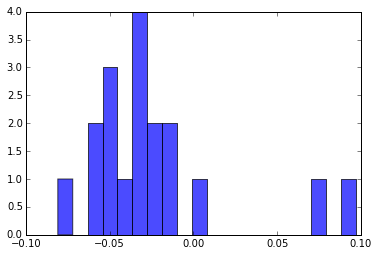

In [318]:
plt.hist(y, bins=20, alpha=0.7)
plt.show()

---

In [ ]:
#poly = PolynomialFeatures(degree=3)
#X_poly = poly.fit_transform(X)

In [334]:
for regr in [LinearRegression(), Ridge(), Lasso(), BayesianRidge(), SGDRegressor(), SVR(), DecisionTreeRegressor(), GradientBoostingRegressor()]:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    skb = SelectKBest()
    skb.fit(X_train,y_train)
    X_train = skb.transform(X_train)
    X_test = skb.transform(X_test)
    
    pca = RandomizedPCA(n_components=2)
    pca.fit(X_train,y_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    pipeline = make_pipeline(regr)
    
    params = dict()
    
    booleans = [True, False]
    alphas = [3, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0]
    max_iter = [1500]
    
    if pipeline.steps[0][0] == 'linearregression':
        params['linearregression__fit_intercept'] = booleans
        params['linearregression__normalize'] = booleans
    if pipeline.steps[0][0] == 'ridge':
        params['ridge__alpha'] = alphas
        params['ridge__fit_intercept'] = booleans
        params['ridge__max_iter'] = max_iter
    if pipeline.steps[0][0] == 'lasso':
        params['lasso__alpha'] = alphas
        params['lasso__fit_intercept'] = booleans
        params['lasso__max_iter'] = max_iter
    if pipeline.steps[0][0] == 'bayesianridge':
        pass
    if pipeline.steps[0][0] == 'sgdregressor':
        pass    
    if pipeline.steps[0][0] == 'svr':
        pass    
    if pipeline.steps[0][0] == 'decisiontreeregressor':
        pass  
    if pipeline.steps[0][0] == 'gradientboostingregressor':
        pass  
    
    #regr = regr.fit(X_train, y_train)
    #print regr.score(X_test, y_test)
    #if regr.score(X_test, y_test) > 0:
    #    print regr
    #    print regr.score(X_test, y_test)

    # tune parameters
    grid_search = GridSearchCV(pipeline, param_grid=params, n_jobs=1)

    grid_search.fit(X_train, y_train)

    print grid_search.best_score_

-1.17356192672
-1.17356192672
-1.17356192672
-2.14318125511
-2.74330794604
-5.1695040098
-1.65171886321
-1.63015193457


---

In [280]:
regr = LinearRegression()
regr = regr.fit(X_train, y_train)
print regr.score(X_test, y_test)
y_pred = regr.predict(X_test)

-1.39037574703


In [265]:
y_pred

array([-0.03393555, -0.04443359,  0.04870605, -0.0423584 ])

In [266]:
y_test

array([-0.03 , -0.024,  0.071, -0.013])